Let's import the libraries we will need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
relative_path = '../datasets/diamonds/diamonds.csv'

Loading the data with Pandas

In [3]:
data = pd.read_csv(relative_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


Looks like there are no missing values or columns with wrong type - great!

Saving the numerical and categorical column names for ease of use

In [4]:
num_cols = [
    'carat',
    'depth',
    'table',
    'x',
    'y',
    'z'
]
cat_cols = [
    'cut',
    'color',
    'clarity',
]
target_col = ['price']

Let's take a look at the data itself

In [5]:
data.sample(5, random_state=42)

,carat,cut,color,clarity,depth,table,price,x,y,z
1501,0.43,Premium,G,VVS1,62.0,59.0,1207,4.80,4.82,2.98
2586,0.35,Ideal,G,IF,61.3,55.0,1001,4.57,4.60,2.81
2653,0.55,Premium,D,SI1,61.6,56.0,1698,5.28,5.24,3.24
1055,0.38,Premium,F,SI1,62.0,58.0,838,4.63,4.60,2.86
705,0.51,Premium,H,SI2,62.9,56.0,1125,5.08,5.06,3.19


In [6]:
data.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


There are negative and zero values for columns that could only be positive (we wouldn't sell a diamond for -1 dollars)

We will drop all rows where there are such problems

In [7]:
data = data[(data[num_cols + target_col] > 0).all(axis=1)]

Firstly, we should look at the column we are trying to predict: the price

<Axes: xlabel='price', ylabel='Count'>

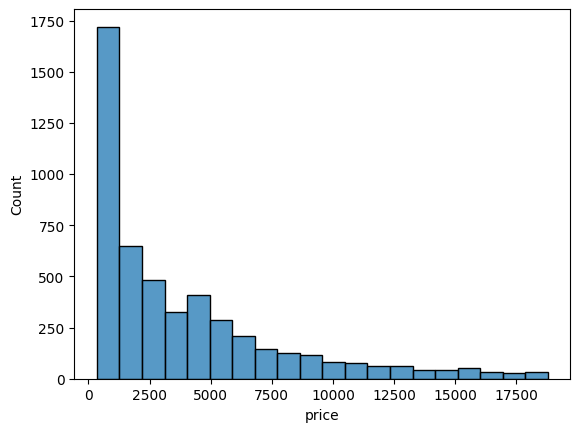

In [8]:
sns.histplot(data, x='price', bins=20)

The more expensive diamonds are much more rare - makes sense

First thing that comes to mind when thinking about a diamond's price is "How many carats is it?"

We can look at the relationship of diamond weight and price

<Axes: xlabel='price', ylabel='carat'>

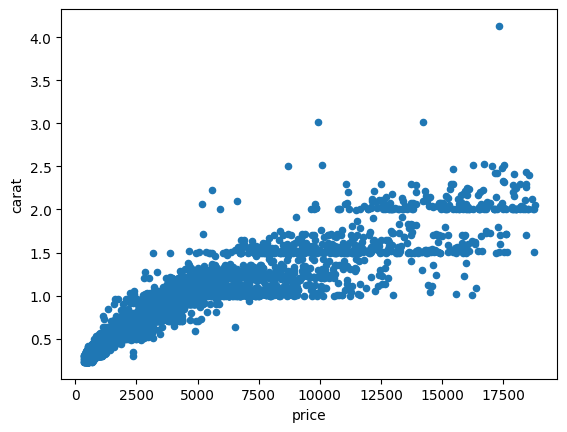

In [9]:
data.plot.scatter(x='price', y='carat')

The more the point cloud in a scatter plot resembles a straight diagonal line - the higher the correlation between the two variables

We can also look at the same plot in log coordinates, where dots are even closer to a diagonal

<Axes: xlabel='price', ylabel='carat'>

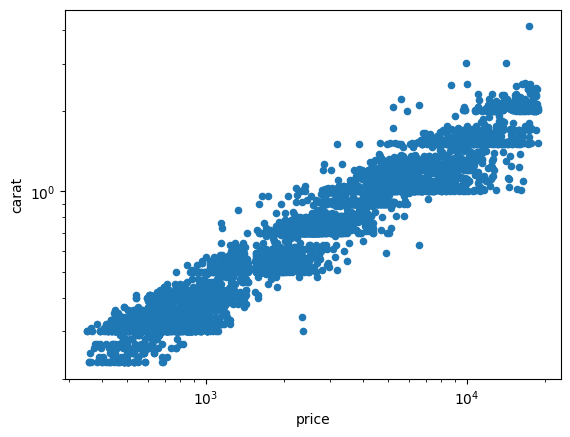

In [10]:
data.plot.scatter(x='price', y='carat', logx=True, logy=True)

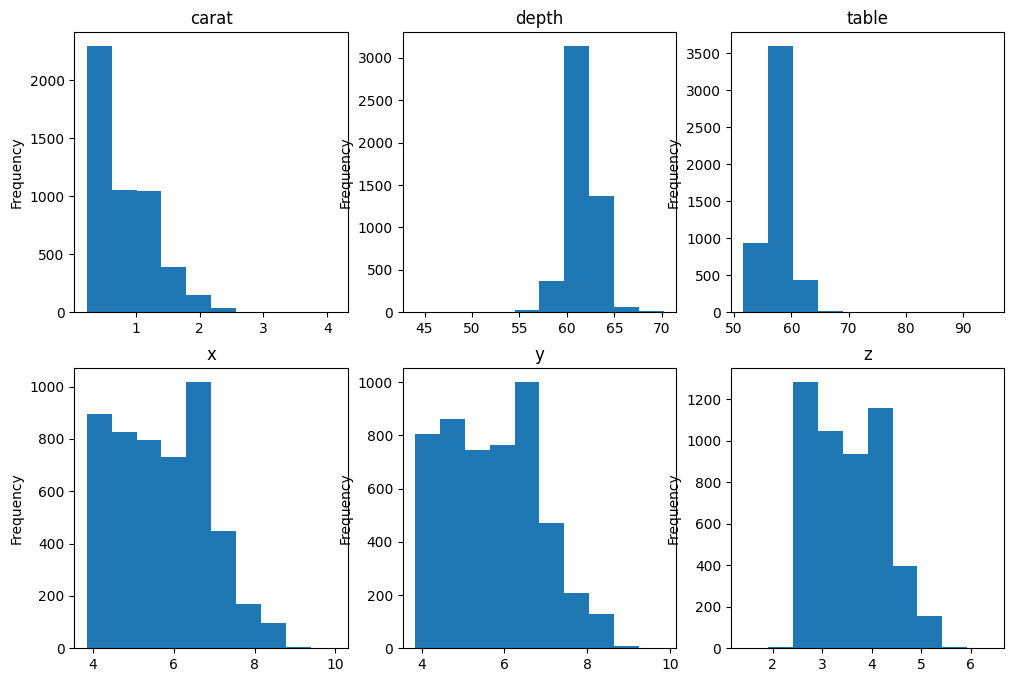

In [11]:
def plot_histograms(df):
    num_plots = len(num_cols)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    for idx, column in enumerate(num_cols):
        ax = axes[idx]
        data[column].plot(kind='hist', ax=ax)
        ax.set_title(column)

    plt.show()


plot_histograms(data)

It seems like the depth and table values have low dispersion - they do not differ much between diamonds.

Next we can look at the same scatter plots as above, but for all numeric columns 

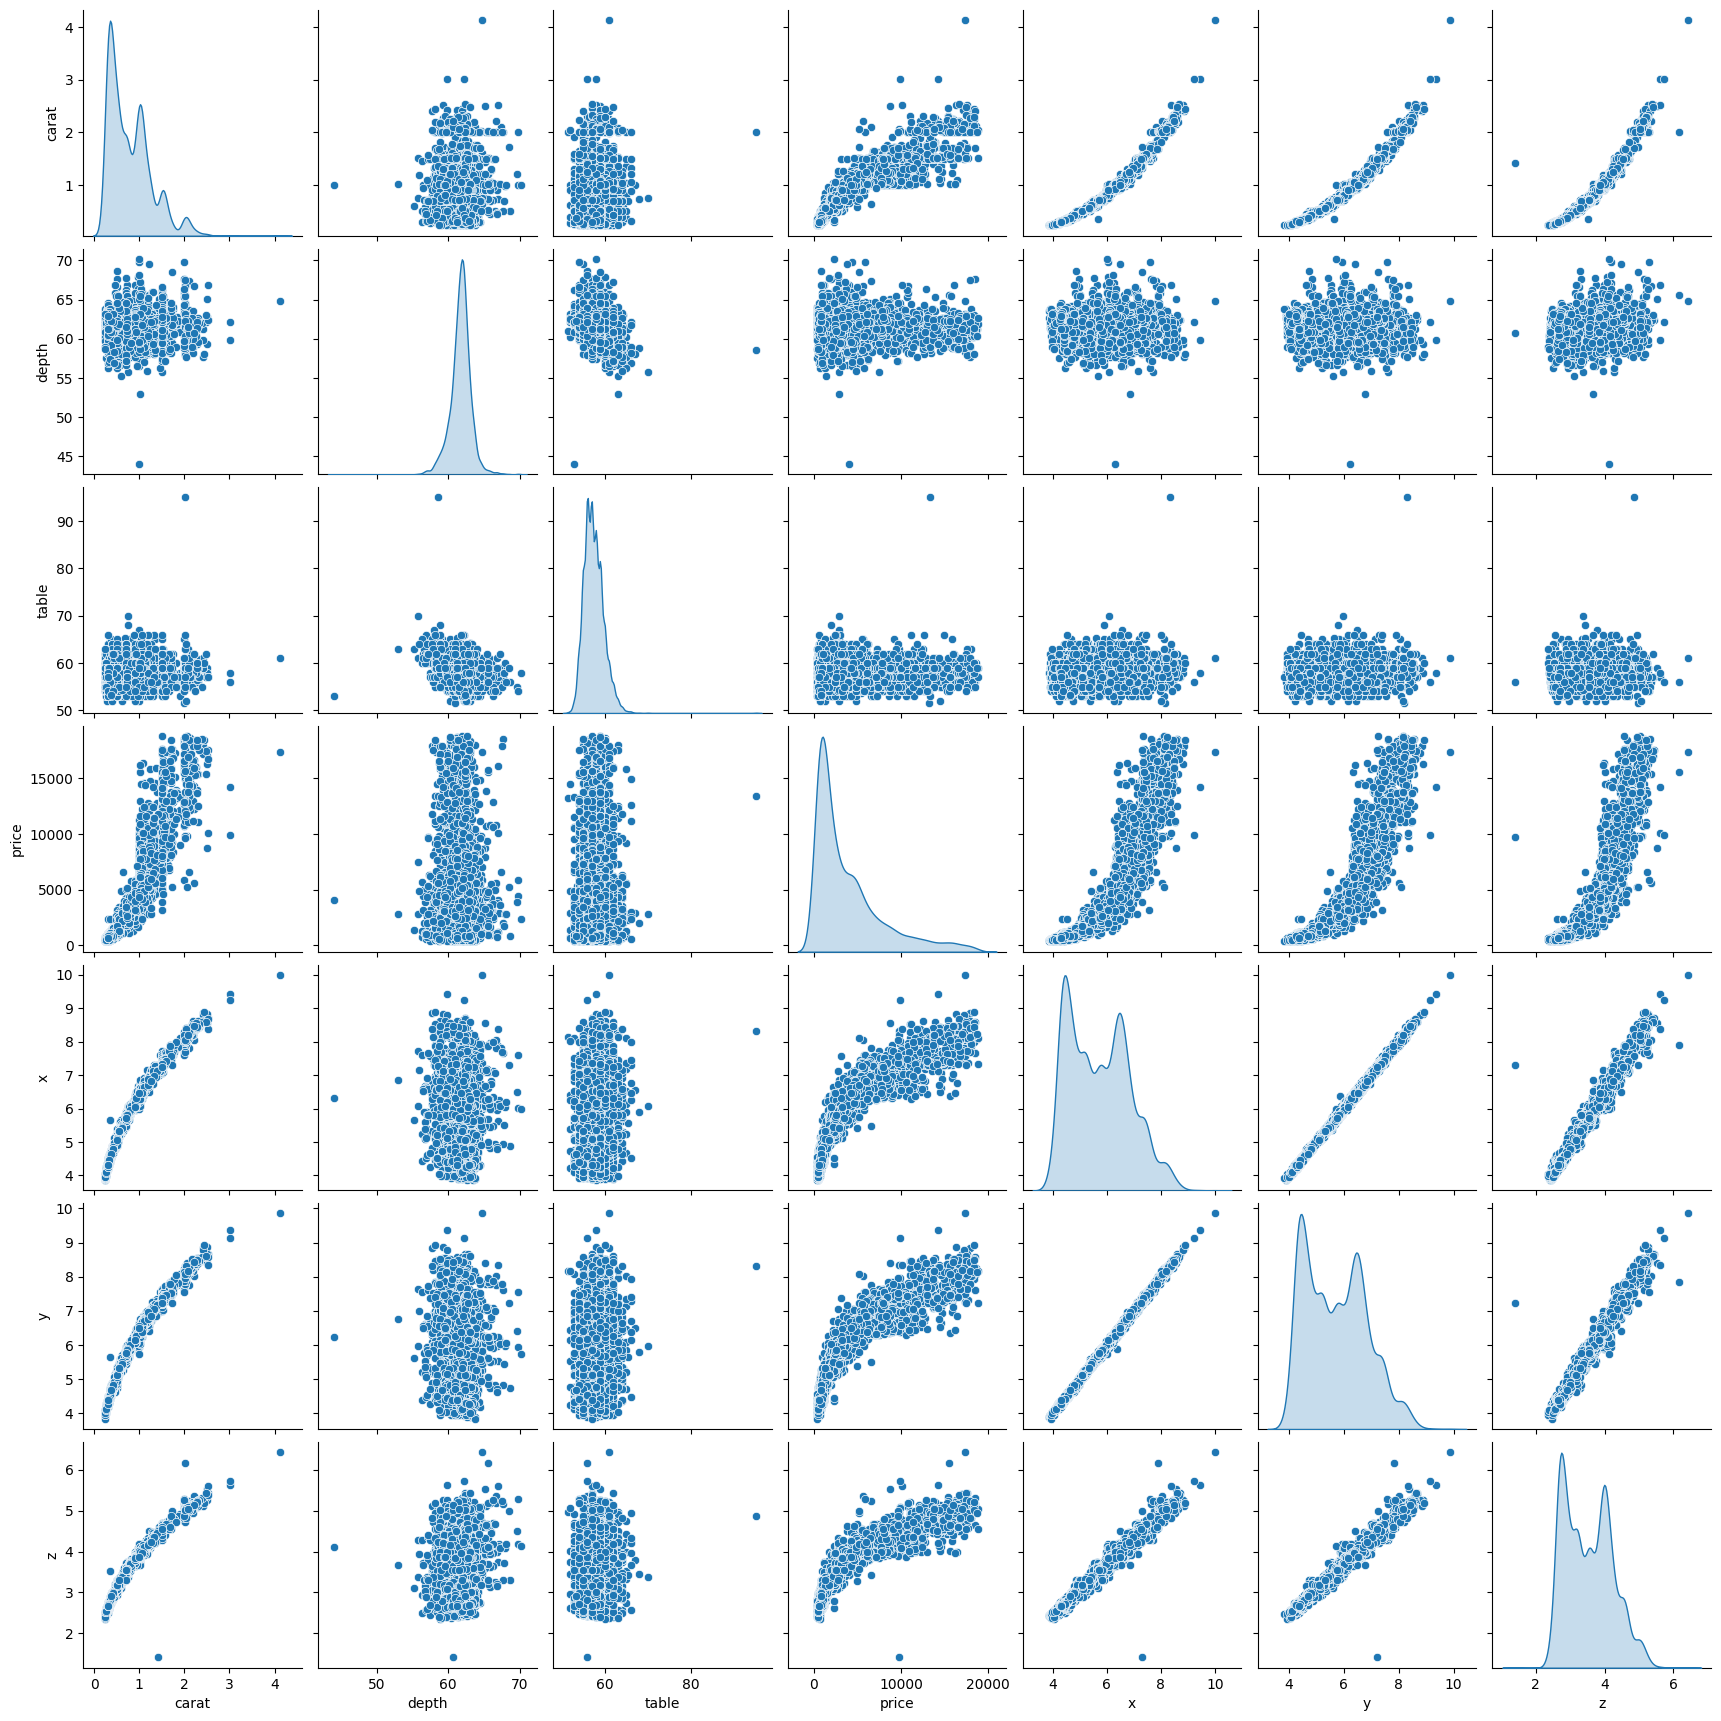

In [13]:
sns.pairplot(data, diag_kind='kde')

If the point cloud resembles a vertical or horizontal line or just a blob, like for most of plots with depth and table, there is no linear correlation between features. 

In [14]:
corr = abs(data[num_cols+target_col].corr(numeric_only=True))
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,carat,depth,table,x,y,z,price
carat,1.000,0.005,0.194,0.979,0.978,0.976,0.921
depth,0.005,1.000,0.324,0.050,0.053,0.072,0.025
table,0.194,0.324,1.000,0.209,0.203,0.164,0.141
x,0.979,0.050,0.209,1.000,0.999,0.989,0.887
y,0.978,0.053,0.203,0.999,1.000,0.989,0.888
z,0.976,0.072,0.164,0.989,0.989,1.000,0.881
price,0.921,0.025,0.141,0.887,0.888,0.881,1.000


The dimensions are highly correlated with each other, with carat weight and with price. We can also see that there is a power law dependence between dimensions and carat weight, whereas depth and table have very little corellation with price. 

<Axes: xlabel='carat', ylabel='volume'>

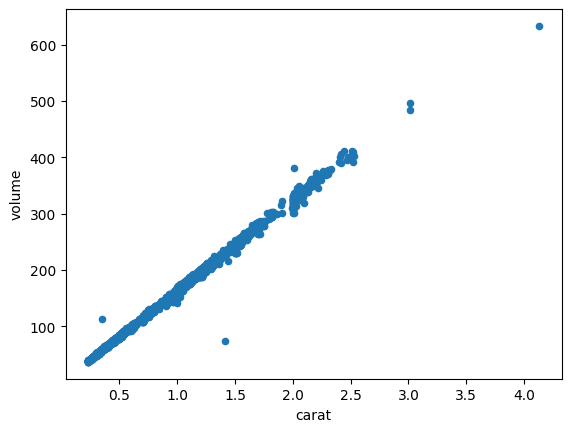

In [20]:
data2 = data.__copy__()
data2['volume'] = data2.x * data2.y * data.z
data2.plot.scatter(x='carat', y='volume')

In the plot above we can see that for most of the diamonds their volume strongly correlates with weight. As diamonds have consistent density, most of the variation and outliers can be contributed to the difference in shape, which is represented by depth and table features. 

However, the diamond price is also influenced by categorical features: cut, color and clarity. (An explanation of these features can be found in the dataset readme file.)

Let's look at the price distribution across categorical features with violin and kde plots.

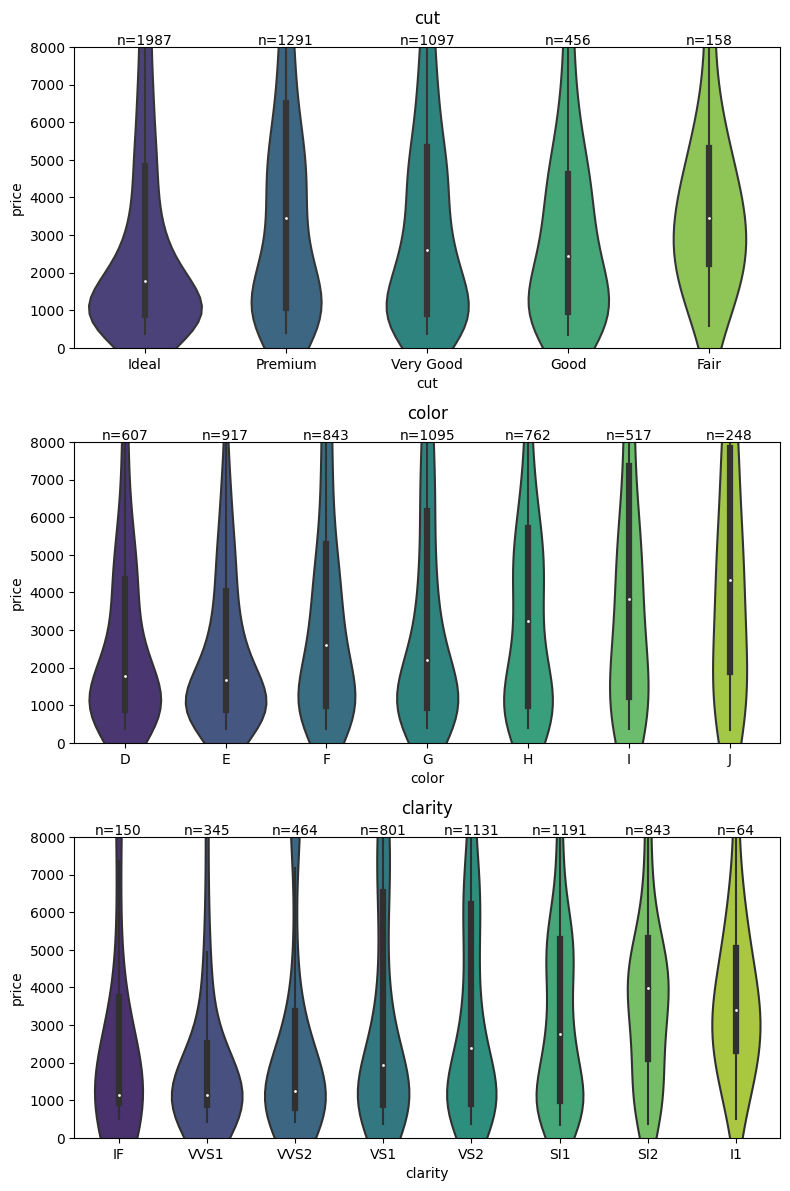

In [15]:
# plot violin plots for all categorical columns
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes = axes.flatten()

custom_orders = {
    'cut': data['cut'].unique(),
    'color': sorted(data['color'].unique()),
    'clarity': ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2','SI1', 'SI2', 'I1']
}

for idx, column in enumerate(cat_cols):
    ax = axes[idx]
    sns.violinplot(
        x=column,
        y='price',
        data=data,
        showfliers=False,
        order=custom_orders[column],
        palette='viridis', 
        ax=ax
        )
    ax.set_title(column, y=1.05)
    ax.set_ylim(bottom=0)
    ax.set_ylim(top=8000)
    
    # Compute category counts and display on plot
    category_counts = data[column].value_counts()
    for i, category in enumerate(custom_orders[column]):
        count = category_counts[category]
        ax.text(i, ax.get_ylim()[1] + 60, 'n=' + str(count), ha='center')
    
plt.tight_layout()
plt.show()

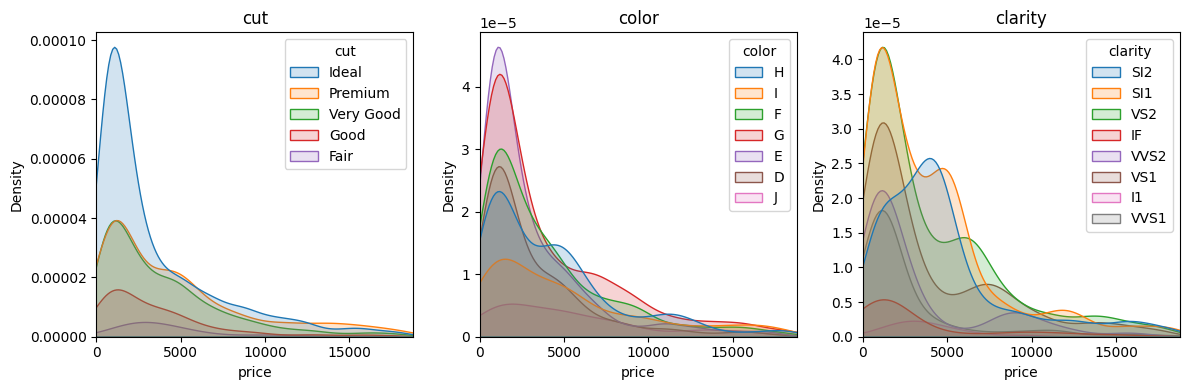

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for idx, column in enumerate(cat_cols):
    ax = axes[idx]
    
    sns.kdeplot(
        x='price',
        hue=column,
        data=data,
        fill=True,
        alpha=0.2,
        ax=ax
        )
    ax.set_title(column)
    ax.set_xlim(left=0)
    ax.set_xlim(right=data['price'].max())
    
plt.tight_layout()
plt.show()

It looks like color and clarity noticeably affect price distribution, while price distrubutions of different cuts are quite similar to each other.